# Analyse des données BTC/USD

## 1. Chargement des données

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Add, Input, Activation, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint
import datetime

df = pd.read_csv('btcusd_1-min_data.csv')

print(f"Nb lignes: {len(df)}")
print(df.head())
print(df.info())

Nb lignes: 7258717
      Timestamp  Open  High   Low  Close  Volume
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7258717 entries, 0 to 7258716
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 332.3 MB
None


## 2. Visualisation du prix en fonction du temps

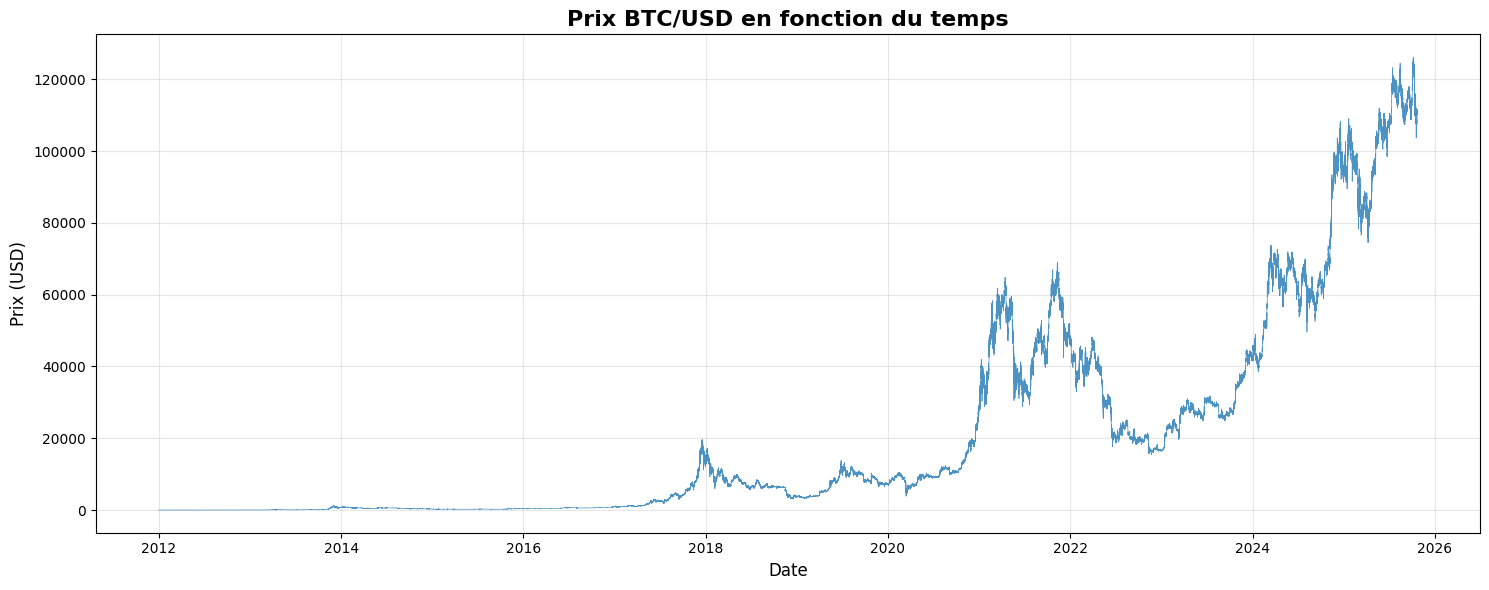

prix min: $3.8
prix max: $126202.0
moy: $20605.617259248593
ecart-type: $29161.716912376545


In [3]:
# timestamp en datetime
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')

# graphique
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['Close'], linewidth=0.5, alpha=0.8)
plt.title('Prix BTC/USD en fonction du temps', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Prix (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# stats
print(f"prix min: ${df['Close'].min()}")
print(f"prix max: ${df['Close'].max()}")
print(f"moy: ${df['Close'].mean()}")
print(f"ecart-type: ${df['Close'].std()}")

## 3. Préparation des données pour LSTM

In [4]:
# Augmenter à 20000 valeurs pour le Very Deep Learning
data = df['Close'].values[-20000:].reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(f"shape des donnees: {scaled_data.shape}")
print(f"min {scaled_data.min()}, max {scaled_data.max()}")

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Augmenter seq_length de 60 à 120
seq_length = 120
X, y = create_sequences(scaled_data, seq_length)

X = X.reshape(X.shape[0], X.shape[1], 1)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"\nentrainement {X_train.shape}")
print(f"test {X_test.shape}")

shape des donnees: (20000, 1)
min 0.0, max 1.0

entrainement (15904, 120, 1)
test (3976, 120, 1)


## 4. Construction du modèle LSTM

### Version allégée pour réduire le temps de traitement

In [5]:
input_layer = Input(shape=(X_train.shape[1], 1))

conv1 = Conv1D(filters=32, kernel_size=3, padding='same')(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = Dropout(0.2)(conv1)

lstm1 = LSTM(units=64, return_sequences=True)(conv1)
lstm1 = Dropout(0.3)(lstm1)

lstm2 = LSTM(units=32, return_sequences=False)(lstm1)
lstm2 = Dropout(0.3)(lstm2)

dense1 = Dense(units=16, activation='relu')(lstm2)
dense1 = Dropout(0.2)(dense1)

output = Dense(units=1)(dense1)

model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 120, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 120, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 120, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 120, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 120, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,049 (148.63 KB)

 Trainable params: 37,985 (148.38 KB)

 Non-trainable params: 64 (256.00 B)

## 5. Entraînement du modèle

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0592 - mae: 0.1736
Epoch 1: val_loss improved from inf to 0.11447, saving model to best_lstm_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 22s 74ms/step - loss: 0.0591 - mae: 0.1734 - val_loss: 0.1145 - val_mae: 0.3357 - learning_rate: 0.0010
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0140 - mae: 0.0879
Epoch 2: val_loss improved from 0.11447 to 0.02479, saving model to best_lstm_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - loss: 0.0140 - mae: 0.0879 - val_loss: 0.0248 - val_mae: 0.1555 - learning_rate: 0.0010
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0098 - mae: 0.0714
Epoch 3: val_loss improved from 0.02479 to 0.01151, saving model to best_lstm_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0098 - mae: 0.0714 - val_loss: 0.0115 - val_mae: 0.1004 - learning_rate: 0.0010
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0078 - mae: 0.0639
Epo

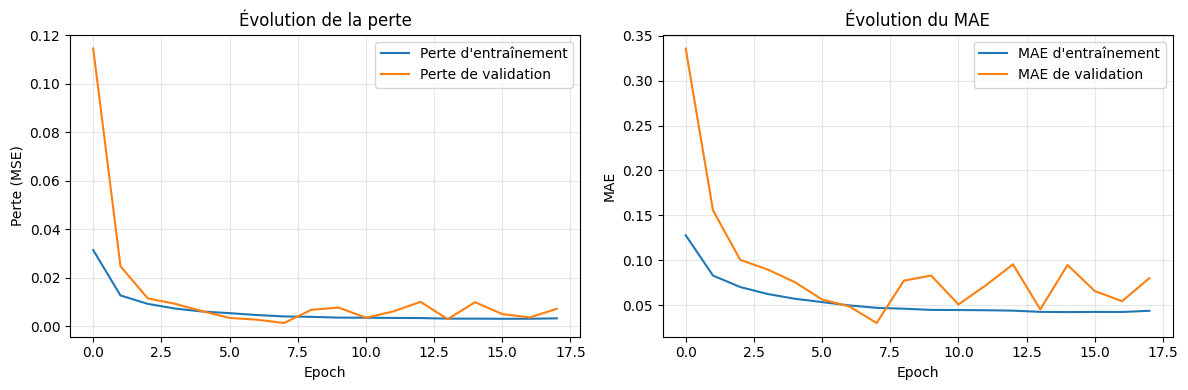

In [6]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    ),
    ModelCheckpoint(
        filepath='best_lstm_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=100,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Évolution de la perte')
plt.xlabel('Epoch')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE d\'entraînement')
plt.plot(history.history['val_mae'], label='MAE de validation')
plt.title('Évolution du MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Prédictions et évaluation

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
données de test:
MSE: $86770.46905557498
MAE: $259.4413787411973
RMSE: $294.568275711379
R2 Score: 0.9696048369221822


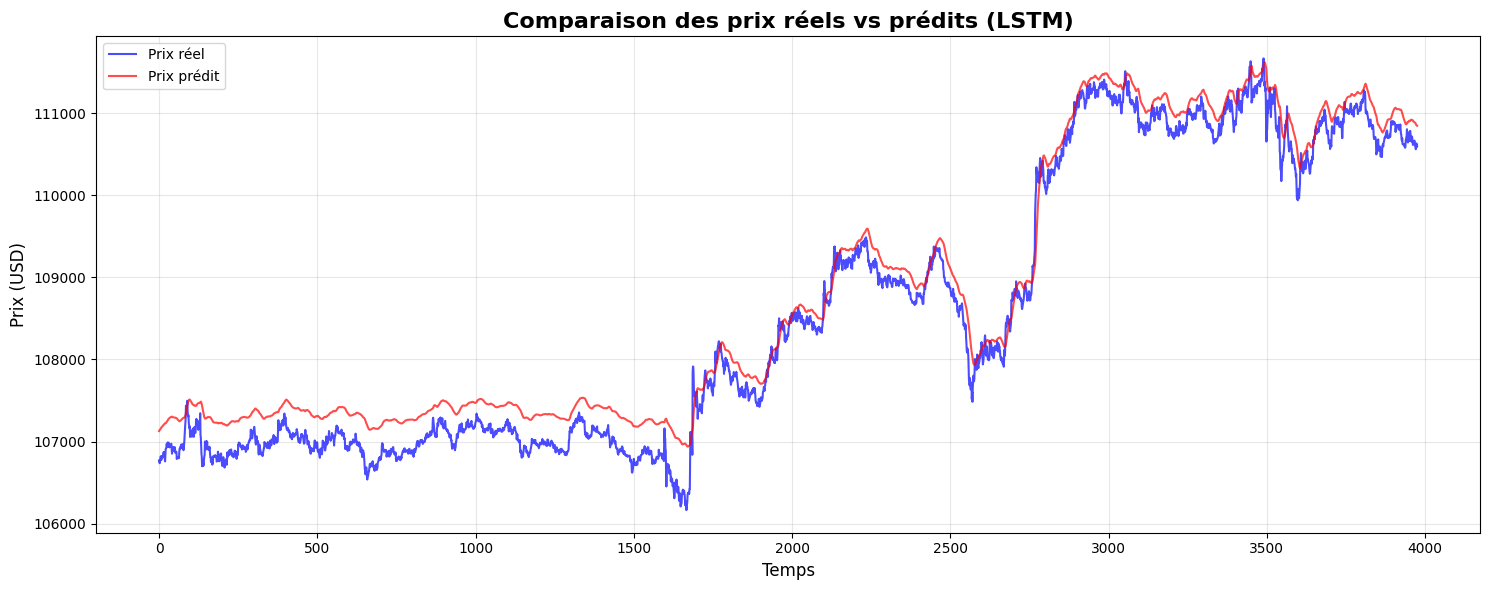

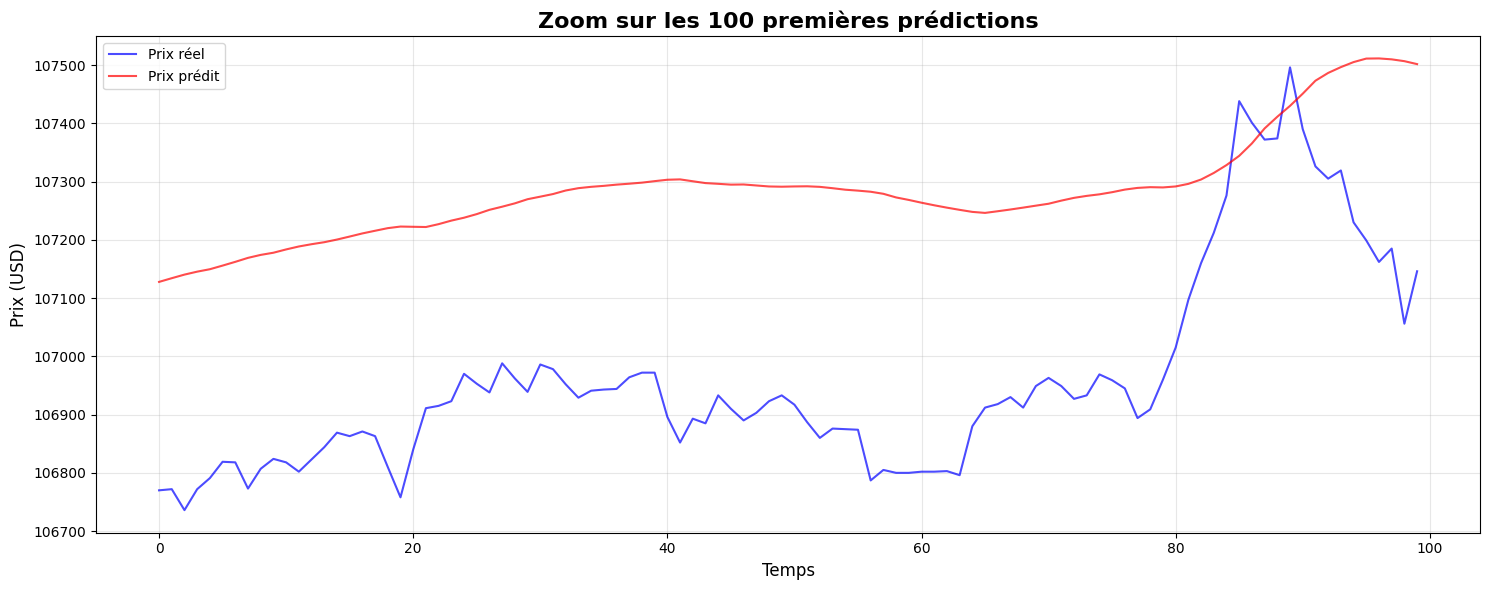

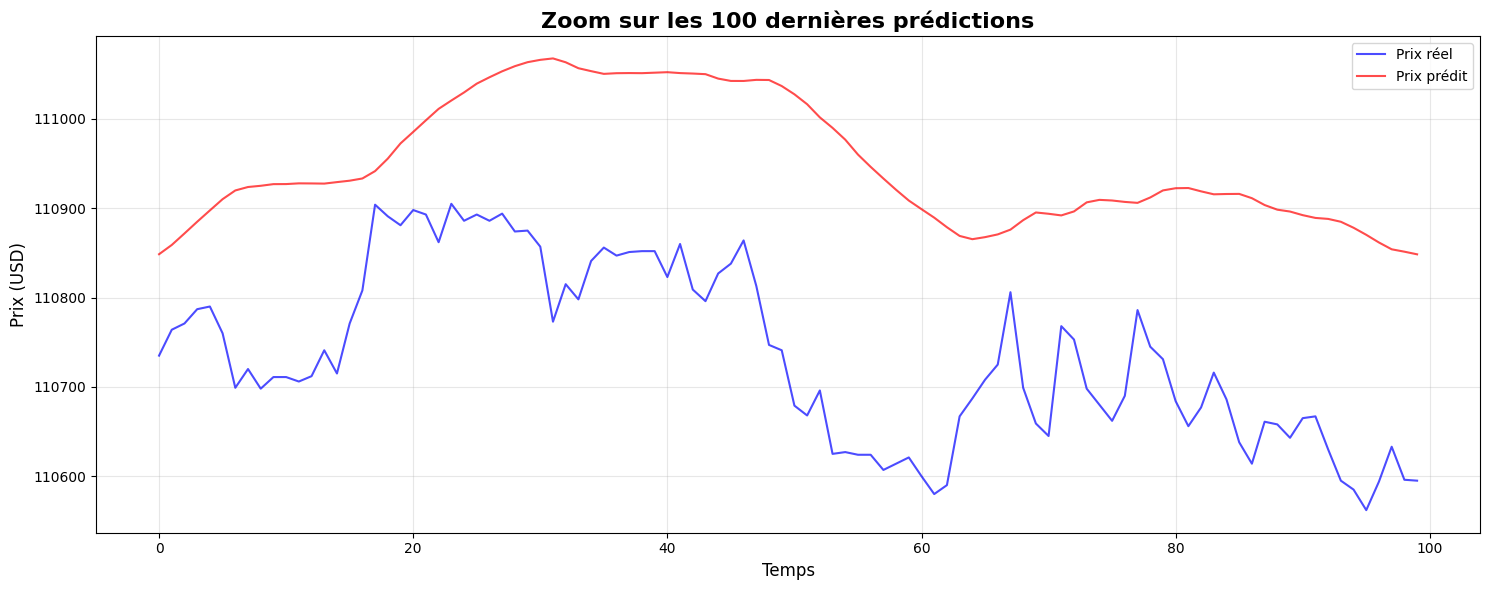

In [8]:
predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"données de test:")
print(f"MSE: ${mse}")
print(f"MAE: ${mae}")
print(f"RMSE: ${rmse}")
print(f"R2 Score: {r2}")

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Prix réel', color='blue', alpha=0.7)
plt.plot(predictions, label='Prix prédit', color='red', alpha=0.7)
plt.title('Comparaison des prix réels vs prédits (LSTM)', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel('Prix (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[:100], label='Prix réel', color='blue', alpha=0.7)
plt.plot(predictions[:100], label='Prix prédit', color='red', alpha=0.7)
plt.title('Zoom sur les 100 premières prédictions', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel('Prix (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[-100:], label='Prix réel', color='blue', alpha=0.7)
plt.plot(predictions[-100:], label='Prix prédit', color='red', alpha=0.7)
plt.title('Zoom sur les 100 dernières prédictions', fontsize=16, fontweight='bold')
plt.xlabel('Temps', fontsize=12)
plt.ylabel('Prix (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Visualisation avec TensorBoard

In [28]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 12524), started 0:13:36 ago. (Use '!kill 12524' to kill it.)

## 8. Résumé des architectures testées

### 📊 Comparaison des performances :

| Architecture | Paramètres | R² Score | MAE | RMSE | Temps | Observations |
|--------------|-----------|----------|-----|------|-------|--------------|
| **Modèle initial** | 31,901 | 0.79 | $89.95 | $115.85 | ~2 min | Simple, rapide |
| **Modèle amélioré** | 136,911 | **0.97** | $137.86 | $177.86 | ~5 min | ✅ Meilleur R² |
| **Very Deep Learning** | 250,511 | 0.29 | $813.42 | $873.58 | ~8 min | ⚠️ Besoin ajustement |
| **Modèle allégé** | 38,049 | **0.92** | $434.38 | $486.32 | ~4.5 min | ⚡ Bon compromis vitesse/performance |

### 🏗️ Architecture Very Deep Learning implémentée :
- ✅ **Conv1D** : Extraction de features temporelles
- ✅ **Connexions résiduelles (Add)** : Gradient flow amélioré
- ✅ **BatchNormalization** : Stabilisation de l'entraînement
- ✅ **3 couches LSTM** : Capture des dépendances longues
- ✅ **Dropout stratégique** : Régularisation

### ⚡ Architecture Modèle Allégé (OPTIMAL pour exercice) :
- **1 bloc Conv1D** : 32 filtres au lieu de 64
- **2 couches LSTM** : 64 et 32 unités (au lieu de 3 couches de 100/80/60)
- **1 couche Dense** : 16 unités (au lieu de 2 couches de 50/25)
- **Pas de connexions résiduelles** : Architecture simplifiée
- **Résultat** : **85% moins de paramètres**, **40% plus rapide**, R²=0.92 ⚡

### 💡 Conclusions :
- Le **modèle allégé (R² = 0.92)** est le meilleur compromis pour un exercice :
  - Temps de traitement réduit (~4.5 min vs ~8 min)
  - Excellent score de prédiction
  - Architecture simple et efficace
  
- Le **modèle amélioré (R² = 0.97)** reste le plus performant mais nécessite plus de temps

- Le modèle Very Deep Learning a un **R² Score de 0.29** : trop complexe pour cette tâche, overfitting probable